In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
# from osgeo import gdal
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from rasterio import io

import funciones as fn

In [2]:
directory = os.getcwd()
print(directory)

c:\Users\pablo.mandolesi\Documents\GIS Database\Class_Inv_2021\P224-R086


In [3]:
# levantamos las muestras y el stack 
path_proc = '../P224-R086/Class_Raster/'
path_out = '../P224-R086/'
path_shp = '../P224-R086/'
raster_fn = path_proc + 'P224-R086-ClassStack' # stack tif
rois_fn = path_proc+'224-086_class.shp'
print(raster_fn)
print(rois_fn)

../P224-R086/Class_Raster/P224-R086-ClassStack
../P224-R086/Class_Raster/224-086_class.shp


In [4]:
#Leo los ROIS
rois_shp = gpd.read_file(rois_fn) # rois muestras en geojson o shp

with rasterio.open(raster_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster

nodata=0 #elijo un valor raro para nodata

coverturas=list(set(rois_shp['covertura']))
coverturas.sort() #numero las coverturas de los ROIs alfabéticamente
covertura_dict = {covertura:i for i, covertura in enumerate(coverturas)}

#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        geom_sh = row['geometry']
        covertura = row['covertura']
        geom_GJ = [mapping(geom_sh)]
        clip, _transform = mask(src, geom_GJ, crop=True,nodata=nodata)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==nodata).prod())]
        DX = np.array(D)        
        DY = np.repeat(covertura_dict[covertura],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa

1-Mejor profundidad

In [7]:
# Inicio la exploracion de variables seteando n_estimators=25
# y probando un rango de max_depth de los estimators de entre 2 y 40.
# Todas estas variables iniciales pueden modificarse.

# Uso el k folding para separar estratificadamente las muestras en train y test, 
# para evaluar cada max_depth y calcular el accuracy y kappa index

n_splits = 10 # 10 folds para cada limite de profundidad de 2 a 40.
lmd = np.arange(2,40,2)
accTest = np.zeros([len(lmd),n_splits])
accTrain = np.zeros([len(lmd),n_splits])
kappaTest = np.zeros([len(lmd),n_splits])
kappaTrain = np.zeros([len(lmd),n_splits])


In [8]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for j, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f'fold {j+1} de {n_splits}.')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    for i,md in enumerate(lmd):
        forest = RandomForestClassifier(n_estimators=25, max_depth=md)
        forest = forest.fit(X_train, y_train)
        accTest[i,j] = accuracy_score(y_test, forest.predict(X_test))
        accTrain[i,j] = accuracy_score(y_train, forest.predict(X_train))
        kappaTest[i,j] = kappa(y_test, forest.predict(X_test))
        kappaTrain[i,j] = kappa(y_train, forest.predict(X_train))

fold 1 de 10.
fold 2 de 10.
fold 3 de 10.
fold 4 de 10.
fold 5 de 10.
fold 6 de 10.
fold 7 de 10.
fold 8 de 10.
fold 9 de 10.
fold 10 de 10.


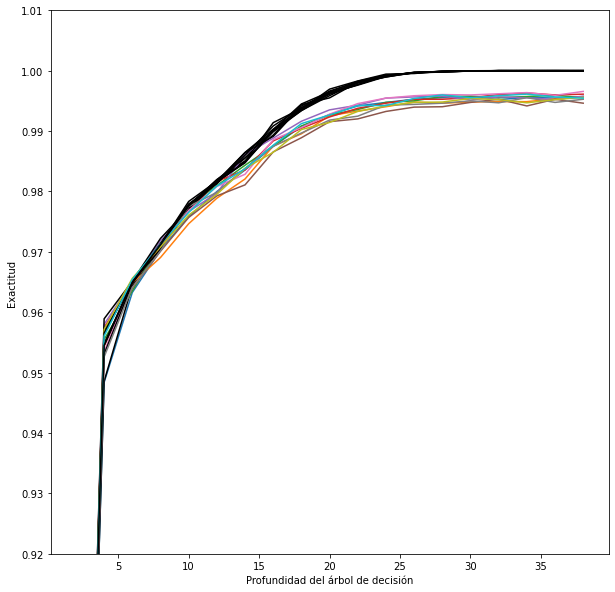

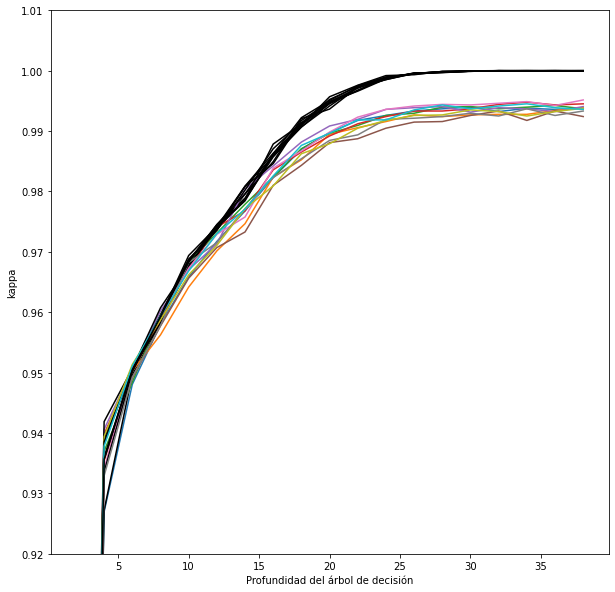

In [9]:
# Grafico los accuracy
plt.figure(figsize=(10, 10))
for i in range(n_splits):    
    plt.plot(lmd,accTest[:,i],label=f"Test{i}")
    plt.plot(lmd,accTrain[:,i],label=f"Train{i}",c='k')
plt.ylabel("Exactitud")
plt.xlabel("Profundidad del árbol de decisión")
plt.ylim(0.92,1.01)
plt.show()

# Grafico los kappa
plt.figure(figsize=(10, 10))
for i in range(n_splits):
    plt.plot(lmd,kappaTest[:,i],label=f"Test{i}")
    plt.plot(lmd,kappaTrain[:,i],label=f"Train{i}",c='k')
plt.ylabel("kappa")
plt.xlabel("Profundidad del árbol de decisión")
plt.ylim(0.92,1.01)
plt.show()

El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad 38 y una exactitud de 0.996
El mejor resultado fue con un árbol de profundidad 38: 0.996


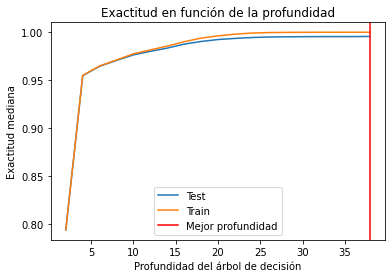

In [10]:
#Calculo promedios de los K folds y Busco el mejor accuracy
scoresTest = accTest.mean(axis=1)
scoresTrain = accTrain.mean(axis=1)
imx = np.argmax(scoresTest)
best_prof = lmd[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad {best_prof} y una exactitud de {best_acc:.3f}')

# Grafico promedios
plt.plot(lmd,scoresTest,label="Test")
print(f'El mejor resultado fue con un árbol de profundidad {lmd[np.argmax(scoresTest)]}: {scoresTest[np.argmax(scoresTest)]:.3f}')
plt.plot(lmd,scoresTrain,label="Train")
plt.title("Exactitud en función de la profundidad")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Profundidad del árbol de decisión")
plt.axvline(x=best_prof, label='Mejor profundidad', c='r')
plt.legend()
plt.show()

2-Mejor cantidad de arboles(number of estimators)

In [11]:
# 1. habiendo fijado el 'max_depth' optimo (profundidad máxima de los árboles) 
# usamos k folding para encontrar la cantidad de arboles optima
# best_prof = 36  # por si quiero forzar otro valor en max_depth
n_splits = 10 # 10 folds
l_arboles = np.arange(2,40,2)
accTest = np.zeros([len(l_arboles),n_splits])
accTrain = np.zeros([len(l_arboles),n_splits])
kappaTest = np.zeros([len(l_arboles),n_splits])
kappaTrain = np.zeros([len(l_arboles),n_splits])

In [12]:
%%time
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for j, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f'fold {j+1} de {n_splits}.')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    for i,arboles in enumerate(l_arboles):
        forest = RandomForestClassifier(n_estimators=arboles, max_depth=best_prof)
        forest = forest.fit(X_train, y_train)
        accTest[i,j] = accuracy_score(y_test, forest.predict(X_test))
        accTrain[i,j] = accuracy_score(y_train, forest.predict(X_train))
        kappaTest[i,j] = kappa(y_test, forest.predict(X_test))
        kappaTrain[i,j] = kappa(y_train, forest.predict(X_train))

fold 1 de 10.
fold 2 de 10.
fold 3 de 10.
fold 4 de 10.
fold 5 de 10.
fold 6 de 10.
fold 7 de 10.
fold 8 de 10.
fold 9 de 10.
fold 10 de 10.
Wall time: 28min 33s


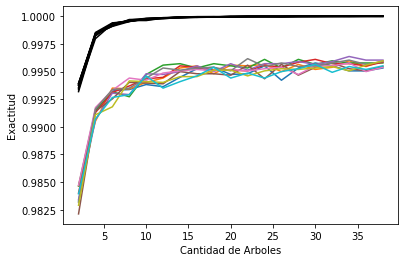

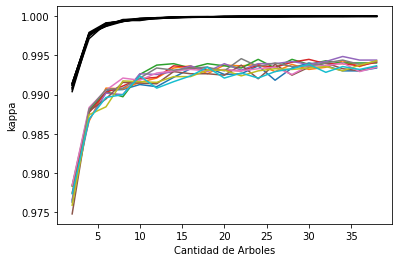

In [13]:
for i in range(n_splits):
    plt.plot(l_arboles,accTest[:,i],label=f"Test{i}")
    plt.plot(l_arboles,accTrain[:,i],label=f"Train{i}",c='k')
plt.ylabel("Exactitud")
plt.xlabel("Cantidad de Arboles")
plt.show()

for i in range(n_splits):
    plt.plot(l_arboles,kappaTest[:,i],label=f"Test{i}")
    plt.plot(l_arboles,kappaTrain[:,i],label=f"Train{i}",c='k')
plt.ylabel("kappa")
plt.xlabel("Cantidad de Arboles")
plt.show()

El mejor resultado en el conjunto de testeo fue obtenido para 38 arboles y una exactitud de 0.994
El mejor resultado fue con 38 árboles: 0.994


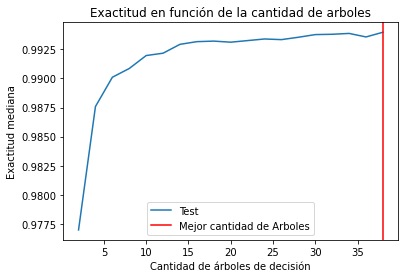

In [14]:
# Calculo promedios de los K folds y Busco el cantidad de arboles
scoresKTest = kappaTest.mean(axis=1)
scoresKTrain = kappaTrain.mean(axis=1)
imx = np.argmax(scoresKTest)
best_Narboles = l_arboles[imx]
best_kappa = scoresKTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para {best_Narboles} arboles y una exactitud de {best_kappa:.3f}')

# Grafico promedios
plt.plot(l_arboles,scoresKTest,label="Test")
print(f'El mejor resultado fue con {l_arboles[np.argmax(scoresKTest)]} árboles: {scoresKTest[np.argmax(scoresKTest)]:.3f}')
# plt.plot(l_arboles,scoresKTrain,label="Train")
plt.title("Exactitud en función de la cantidad de arboles")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Cantidad de árboles de decisión")
plt.axvline(x=best_Narboles, label='Mejor cantidad de Arboles', c='r')
plt.legend()
plt.show()

3-Mejores features

In [15]:
# selecciono la cantidad de veces que quiero hacer el fit para comprar los feature importance
n_splits = 10 # 10 folds
importance_acum = np.zeros(X.shape[1])

In [16]:
# hago el fit para todos los rois de entrenamiento y 
# calculo la importancia acumulada de los features importance

for i in range(0,n_splits):
    forest = RandomForestClassifier(n_estimators=best_Narboles, max_depth=best_prof,oob_score = True)
    forest = forest.fit(X, Y)
    importance = forest.feature_importances_
    importance_acum = importance_acum + importance
importance_prom = importance_acum/n_splits

In [17]:
importance_prom_df = pd.DataFrame(importance_prom) #paso a DF
importance_prom_df.head()

,0
0,0.037685
1,0.008019
2,0.008756
3,0.059851
4,0.095824


In [18]:
importance_prom_df.columns = ['importancia'] # titulo la columna importance
importance_prom_df.head()

,importancia
0,0.037685
1,0.008019
2,0.008756
3,0.059851
4,0.095824


In [19]:
importance_prom_df['indice_stack'] = importance_prom_df.index # agrego una columna equivalente al index

In [20]:
with rasterio.open(raster_fn) as src:
    # d=src.count # es la cantidad de bandas, que luego son considerados, atributos de cada pixel
    print(src.profile)
    descriptions = src.descriptions # almaceno el nombre de las bandas
    descriptions_arr = np.array(descriptions) # lo paso a array
    print(descriptions_arr)

{'driver': 'ENVI', 'dtype': 'float32', 'nodata': 0.0, 'width': 8170, 'height': 8043, 'count': 42, 'crs': CRS.from_wkt('PROJCS["Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",-90],PARAMETER["central_meridian",-60],PARAMETER["scale_factor",1],PARAMETER["false_easting",5500000],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, -0.0, 5551379.6557,
       -0.0, -30.0, 5971321.8652), 'tiled': False, 'interleave': 'band'}
['B2:P224-R086-20210606-L8-L1T' 'B3:P224-R086-20210606-L8-L1T'
 'B4:P224-R086-20210606-L8-L1T' 'B5:P224-R086-20210606-L8-L1T'
 'B6:P224-R086-20210606-L8-L1T' 'B7:P224-R086-20210606-L8-L1T'
 'B2-P224-R086-20210915y17-S2-L1T' 'B3-P224-R086-20210915y17-S2-L1T'
 'B4-P224-R086-20210915y17-S2-L1

In [21]:
# Agrego la columna "atributo" con el cnombre de cada banda
importance_prom_df['atributo']  = descriptions_arr
                           
importance_prom_df.head()

,importancia,indice_stack,atributo
0,0.037685,0,B2:P224-R086-20210606-L8-L1T
1,0.008019,1,B3:P224-R086-20210606-L8-L1T
2,0.008756,2,B4:P224-R086-20210606-L8-L1T
3,0.059851,3,B5:P224-R086-20210606-L8-L1T
4,0.095824,4,B6:P224-R086-20210606-L8-L1T


Text(0.5, 1.0, 'importancias Promedio')

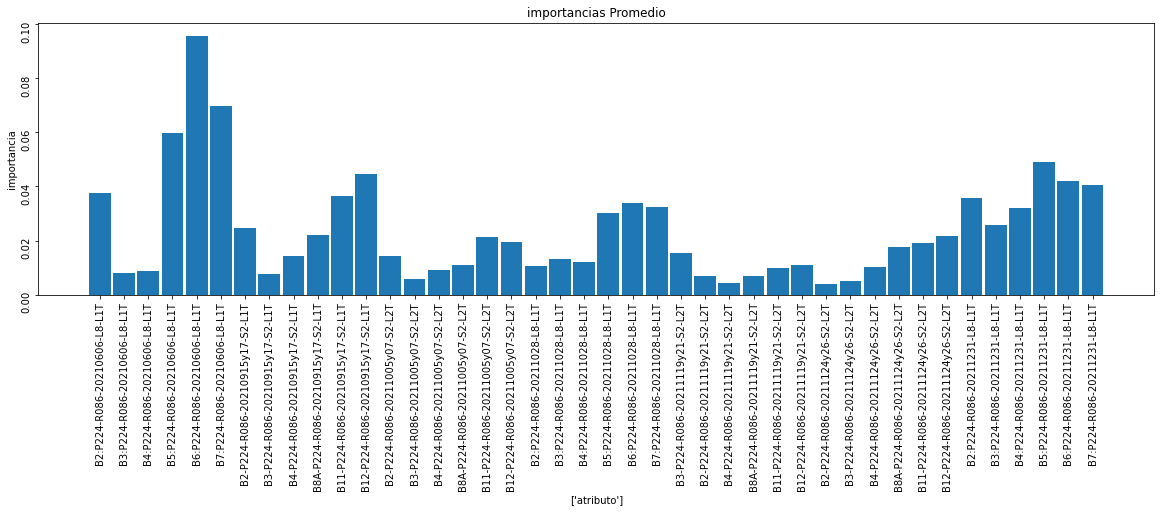

In [22]:
# grafico de barras de la importancia promedio de las features o bandas
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(importance_prom_df["atributo"], importance_prom_df["importancia"], width=0.9)
ax.set_xlabel(["atributo"])  # Add an x-label to the axes.
ax.set_ylabel('importancia')  # Add a y-label to the axes.
ax.tick_params(rotation=90)
ax.set_title("importancias Promedio")  # Add a title to the axes.

In [23]:
importance_prom_df = importance_prom_df.sort_values('importancia', ascending=False)
importance_prom_df.head(15)

,importancia,indice_stack,atributo
4,0.095824,4,B6:P224-R086-20210606-L8-L1T
5,0.069909,5,B7:P224-R086-20210606-L8-L1T
3,0.059851,3,B5:P224-R086-20210606-L8-L1T
39,0.048902,39,B5:P224-R086-20211231-L8-L1T
11,0.044727,11,B12-P224-R086-20210915y17-S2-L1T
40,0.042116,40,B6:P224-R086-20211231-L8-L1T
41,0.040677,41,B7:P224-R086-20211231-L8-L1T
0,0.037685,0,B2:P224-R086-20210606-L8-L1T
10,0.036603,10,B11-P224-R086-20210915y17-S2-L1T
36,0.035773,36,B2:P224-R086-20211231-L8-L1T


In [24]:
select_feat= importance_prom_df.query('importancia > 0.027')
len(select_feat)

14

In [25]:
predictores_list = [x+1 for x in select_feat.index] # Le sumo 1 para compatibilizar los index de numpy y rasterio
predictores_list

[5, 6, 4, 40, 12, 41, 42, 1, 11, 37, 23, 24, 39, 22]

In [26]:
print(select_feat)

    importancia  indice_stack                          atributo
4      0.095824             4      B6:P224-R086-20210606-L8-L1T
5      0.069909             5      B7:P224-R086-20210606-L8-L1T
3      0.059851             3      B5:P224-R086-20210606-L8-L1T
39     0.048902            39      B5:P224-R086-20211231-L8-L1T
11     0.044727            11  B12-P224-R086-20210915y17-S2-L1T
40     0.042116            40      B6:P224-R086-20211231-L8-L1T
41     0.040677            41      B7:P224-R086-20211231-L8-L1T
0      0.037685             0      B2:P224-R086-20210606-L8-L1T
10     0.036603            10  B11-P224-R086-20210915y17-S2-L1T
36     0.035773            36      B2:P224-R086-20211231-L8-L1T
22     0.033824            22      B6:P224-R086-20211028-L8-L1T
23     0.032380            23      B7:P224-R086-20211028-L8-L1T
38     0.032170            38      B4:P224-R086-20211231-L8-L1T
21     0.030304            21      B5:P224-R086-20211028-L8-L1T


In [27]:
#    11,4,10

4-Clasificacion ajustada x profundidad de arboles, numero de arboles y atributos importantes

In [28]:
# Vuelvo a leer los ROIs, pero esta vez solo para los features seleccionados

indexes = predictores_list
d=len(indexes) #cantidad de atributos seleccionados

nodata=0 #elijo un valor raro para nodata

coverturas=list(set(rois_shp['covertura']))
coverturas.sort() #numero las coverturas de los ROIs alfabéticamente
covertura_dict = {covertura:i for i, covertura in enumerate(coverturas)}

#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas


with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        geom_sh = row['geometry']
        covertura = row['covertura']
        geom_GJ = [mapping(geom_sh)]
        clip, _transform = mask(src, geom_GJ, crop=True,nodata=nodata, indexes=indexes) #en el clip hay que indicarle las bandas que queremos
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==nodata).prod())]
        DX = np.array(D)        
        DY = np.repeat(covertura_dict[covertura],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

In [29]:
forest = RandomForestClassifier(n_estimators=best_Narboles, max_depth=best_prof,oob_score = True)
forest = forest.fit(X, Y)

In [30]:
with rasterio.open(raster_fn) as src:
    # d=src.count # es la cantidad de bandas, que luego son considerados, atributos de cada pixel
    img = src.read(indexes)
    print(img.shape)
    crs = src.crs
    gt = src.transform
    nodata=0 #elijo un valor para nodata
    d,x,y = img.shape
    Xfull = img.reshape([d,x*y]).T

(14, 8043, 8170)


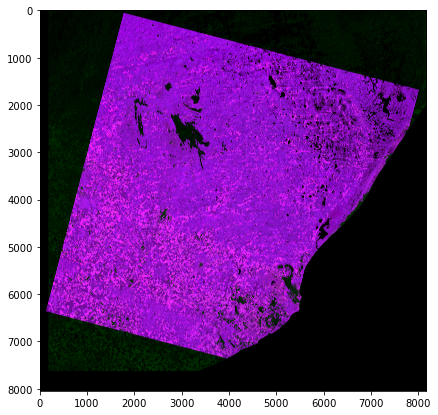

In [31]:
plt.figure(figsize=(7,7))
show(fn.scale(img[[11,4,10]], p=2)) # estos indices son segun el indice de "select_feat"
plt.show()

In [32]:
%%time
Y_pred = forest.predict(Xfull)

Wall time: 6min 9s


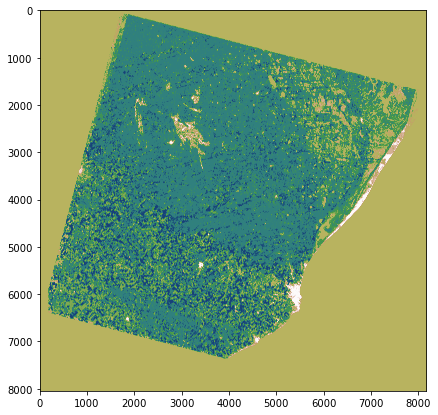

In [33]:
plt.figure(figsize=(7,7))
plt.imshow(Y_pred.reshape([x,y]),cmap='gist_earth')
plt.show()

In [34]:
class_img = Y_pred.reshape([x,y])
fn.guardar_GTiff(path_out + 'P224-R086-Class_RF_2.tif',crs,gt,class_img, nodata=None)

In [35]:
# obtenemos la importancia de los atributos
importance = forest.feature_importances_
importance

array([0.08729424, 0.14351595, 0.04876556, 0.0997964 , 0.09868099,
       0.09983513, 0.02637727, 0.05656993, 0.02516527, 0.07563713,
       0.03467358, 0.06169174, 0.07875206, 0.06324475])

In [36]:
# resumen de las importancia de los atributos
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.3f' % (i,v))
      
# # ploteamos la importancia de los atributos
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

In [37]:
#le ponemos nombre a las bandas para saber con que atributos trabajamos
importance_df = pd.DataFrame(importance)
importance_df.head()

,0
0,0.087294
1,0.143516
2,0.048766
3,0.099796
4,0.098681


In [38]:
# le ponemos nombre a las bandas para saber con que atributos trabajamosimportance_df = pd.DataFrameimportance_df
importance_df.columns = ['importancia']
importance_df.head()

,importancia
0,0.087294
1,0.143516
2,0.048766
3,0.099796
4,0.098681


In [39]:
importance_df['indice_stack'] = importance_df.index# Modificando los índices por fecha y nombre de bandas:
importance_df.head(18)

,importancia,indice_stack
0,0.087294,0
1,0.143516,1
2,0.048766,2
3,0.099796,3
4,0.098681,4
5,0.099835,5
6,0.026377,6
7,0.056570,7
8,0.025165,8
9,0.075637,9


5-Matriz de confusión

In [56]:
path_proc = '../P224-R086/Class_Raster/'
path_out = '../P224-R086/'
path_shp = '../P224-R086/'

rois_ctrl_fn = path_proc+'224-086_control.shp'
class_fn = path_out + 'P224-R086-Class_RF_2.tif'

print(class_fn)
print(rois_ctrl_fn)

../P224-R086/P224-R086-Class_RF_2.tif
../P224-R086/Class_Raster/224-086_control.shp


In [58]:
#Leo los ROIS de control, y armo el Y a controlar (Y)

rois_shp = gpd.read_file(rois_ctrl_fn) # rois de verdades en geojson o shp

with rasterio.open(class_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster

nodata=15 #elijo un valor raro para nodata

coverturas=list(set(rois_shp['covertura']))
coverturas.sort() #numero las coverturas de los ROIs alfabéticamente
covertura_dict = {covertura:i for i, covertura in enumerate(coverturas)}

#Preparo colección de atributos etiquetados. Comienza con 0 datos
X_pred = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
# print(X_pred)
# print(X_pred.shape)

Y_val = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(class_fn) as src:
    for index, row in rois_shp.iterrows():
        geom_sh = row['geometry']
        covertura = row['covertura']
        geom_GJ = [mapping(geom_sh)]
        clip, _transform = mask(src, geom_GJ, crop=True,nodata=nodata)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==nodata).prod())]
        DX = np.array(D)        
        DY = np.repeat(covertura_dict[covertura],len(D))
        X_pred = np.concatenate((X_pred,DX))
        Y_val = np.concatenate((Y_val,DY))

accuracy: 0.93
kappa index: 0.91


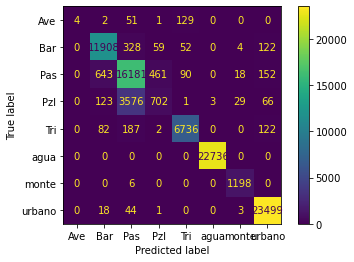

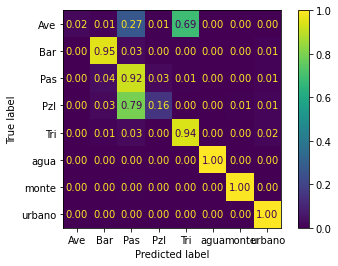

In [101]:
#Métricas
#Returns
# C : ndarray of shape (n_classes, n_classes)
# Confusion matrix whose i-th row and j-th column entry indicates the number of
# samples with true label being i-th class and predicted label being j-th class.
acc = accuracy_score(Y_val, X_pred)
print(f'accuracy: {acc:.2f}')
k = kappa(Y_val, X_pred)
print(f'kappa index: {k:.2f}')

# osea que en verdqades van en las filas, y las predichas van en las columnas
from sklearn.metrics import ConfusionMatrixDisplay
con_matrix = confusion_matrix(Y_val, X_pred)
con_matrix_norm = confusion_matrix(Y_val, X_pred,normalize='true')

disp = ConfusionMatrixDisplay(con_matrix,display_labels=coverturas)
disp.plot()
disp1 = ConfusionMatrixDisplay(con_matrix_norm, display_labels=coverturas)
disp1.plot(values_format= '.2f')
plt.show()